In [1]:
import pandas as pd
import geopandas
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
csv = "bundesliga.csv"
df = pd.read_csv(csv, index_col=[0])
df.head()

,Player,National Team,Club,Position,Birthplace,Number,lat,lon
0,Manuel Neuer,Germany,FC Bayern Munchen,GK,"Gelsenkirchen,Germany",1.0,51.511032,7.096012
1,Sven Ulreich,Germany,FC Bayern Munchen,GK,"Schorndorf,Germany",26.0,48.805517,9.527266
2,Christian Früchtl,Germany,FC Bayern Munchen,GK,"Bischofsmais,Germany",36.0,48.918615,13.080915
3,Dayout Upamecano,France,FC Bayern Munchen,D,"Evreux,France",2.0,49.026890,1.151016
4,Lucas Hernandez,France,FC Bayern Munchen,D,"Marseille,France",21.0,43.296174,5.369953


In [3]:
#Create series from birthplace column to check number of overlapping points
ds = df['Birthplace'].value_counts()
ds.describe()

count    379.000000
mean       1.353562
std        1.206927
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       16.000000
Name: Birthplace, dtype: float64

In [4]:
ds[ds > 1].count()

61

## Problem - visualize overlapping points
This data is going to be displayed on a webmap representing birth locations by city.  
However, there are 513 player to be represented yet there are 379 birthplaces (cities).  
This leaves **61 cities with more than one player.** Since this dataset was geocoded by city,  
**players born in the same city will share the same coordinates.**

## Solution - offset coordinates from center point
Since I want to replicate this, I needed to come up with a reproducible way to modify the coordinates
from a given input. The max number of players born in the same city is 16, but if I want to do this
with another league, I should anticipate up to 50 players born in the same city. I decided to offset the
points into layers of circles surrounding the central coordinates. I wanted the first circle to have 4 points and the subsequent circles to increase by 4. I accomplish this by roughly using the equation 2x^2 + 2x and solving it using the quadratic formula.



In [5]:
# Takes nth overlapping point and ouputs coordinates for location on circle
def radius(n, show=False):
    
    radius = math.ceil((-2 + (math.sqrt(4 - 8 * -(n))))/4 )
    
    position = n - (2*((radius - 1)**2) + (2*(radius - 1)))

    nPositions = (radius * 4)

    angle = (360/nPositions)*position

    xCoord = np.cos((np.pi/180) * angle) * (radius/100)
    yCoord = np.sin((np.pi/180) * angle) * (radius/100)
    
    xCoord = (round(xCoord, 4))
    yCoord = (round(yCoord, 4))
    
    if show == True:
        print(
            f''' # of Points to Display: {n}\n # of Circles: {radius}\n Position in Circle: {position}\n Points in Circle: {nPositions}  \n Angle: {angle}  \n xCoord: {xCoord} yCoord: {yCoord}\n''')

    return([xCoord,yCoord])

In [6]:
testPoints = [4,5,12,13]
for n in testPoints:
    radius(n, show=True)

 # of Points to Display: 4
 # of Circles: 1
 Position in Circle: 4
 Points in Circle: 4  
 Angle: 360.0  
 xCoord: 0.01 yCoord: -0.0

 # of Points to Display: 5
 # of Circles: 2
 Position in Circle: 1
 Points in Circle: 8  
 Angle: 45.0  
 xCoord: 0.0141 yCoord: 0.0141

 # of Points to Display: 12
 # of Circles: 2
 Position in Circle: 8
 Points in Circle: 8  
 Angle: 360.0  
 xCoord: 0.02 yCoord: -0.0

 # of Points to Display: 13
 # of Circles: 3
 Position in Circle: 1
 Points in Circle: 12  
 Angle: 30.0  
 xCoord: 0.026 yCoord: 0.015



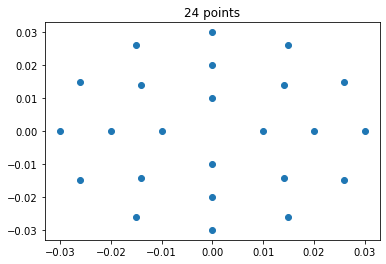

In [7]:
# Example of radius function for 24 overlapping points

i = 1
arr = []
while i < 25:  
    arr.append(radius(i))  
    i = i + 1
arr = np.array(arr)
x, y = arr.T
plt.scatter(x, y)
plt.title('24 points')
plt.show()

In [8]:
def radiusDf(n):
    i = 1
    arr = []
    while i < n + 1:  
        arr.append(radius(i))  
        i = i + 1
    arr = np.array(arr)
    dfR = pd.DataFrame(arr, columns=['x','y'])
    return(dfR)

In [19]:
df_in = df.set_index('Player')
#Get pandas series of number of birth for each city and create a df of every city with more than one
cityBirthCount = df.Birthplace.value_counts().reset_index()
moreThanOne = cityBirthCount[cityBirthCount.Birthplace > 1]
df_in.head()



,National Team,Club,Position,Birthplace,Number,lat,lon
Player,,,,,,,
Manuel Neuer,Germany,FC Bayern Munchen,GK,"Gelsenkirchen,Germany",1.0,51.511032,7.096012
Sven Ulreich,Germany,FC Bayern Munchen,GK,"Schorndorf,Germany",26.0,48.805517,9.527266
Christian Früchtl,Germany,FC Bayern Munchen,GK,"Bischofsmais,Germany",36.0,48.918615,13.080915
Dayout Upamecano,France,FC Bayern Munchen,D,"Evreux,France",2.0,49.026890,1.151016
Lucas Hernandez,France,FC Bayern Munchen,D,"Marseille,France",21.0,43.296174,5.369953


In [23]:
for index,row in moreThanOne.iterrows():  

    city = row[0]
    k = row[1]
    dfCity = df_in[df_in.Birthplace == city].reset_index()

    x = radiusDf(k)

    df2 = pd.concat([x,dfCity],axis=1)
    df2['lon'] = df2['lon'] + df2['y']
    df2['lat'] = df2['lat'] + df2['x']
    df2 = df2.drop(columns = ['x','y']).set_index('Player')
    df_in.update(df2)

In [24]:
#Players born in Berlin with modified coordinates
Berlin = df_in[df_in.Birthplace == 'Berlin,Germany']
Berlin

,National Team,Club,Position,Birthplace,Number,lat,lon
Player,,,,,,,
Nico Schulz,Germany,Borussia Dortmund,D,"Berlin,Germany",14.0,52.517037,13.41886
Luca Netz,Germany,Borussia Monchengladbach,D,"Berlin,Germany",20.0,52.487037,13.38886
John Anthony Brooks,USA,VfL Wolfsburg,D,"Berlin,Germany",25.0,52.517037,13.35886
Maximilian Philipp,Germany,VfL Wolfsburg,F,"Berlin,Germany",17.0,52.547036,13.38886
Chrisopher Lenz,Germany,Eintracht Frankfurt,D,"Berlin,Germany",25.0,52.559337,13.43116
Fabian Bredlow,Germany,VfB Stuttgart,GK,"Berlin,Germany",33.0,52.517037,13.44886
Nils-Jonathan Korber,Germany,Hertha BSC,GK,"Berlin,Germany",12.0,52.474737,13.43116
Marton Dardai,Germany,Hertha BSC,D,"Berlin,Germany",31.0,52.457036,13.38886
Maximilian Mittelstadt,Germany,Hertha BSC,D,"Berlin,Germany",17.0,52.474737,13.34656
